In [30]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [82]:
df = pd.read_excel('so_data.xlsx')

In [88]:
df[(df['product']=='A') & (df['season']=='summer')].max()

product                       A
season                   summer
discount_percentage    0.266667
sales_uplift_norm      0.356849
dtype: object

In [4]:
def pre_process_data(df,product):
    data = df.copy().reset_index()
#     print(data)
    bp = product
    print("----------product: {}----------".format(bp))
    # Pre-processing steps
    print("pre process df.shape {}".format(df.shape))
        #1. Reponse var transformation
    response = data.sales_uplift_norm # already transformed

        #2. predictor numeric var transformation 
    numeric_vars = ['discount_percentage'] # may include mrp, depth
    df_numeric = data[numeric_vars]
    df_norm = df_numeric.apply(lambda x: scale(x), axis = 0) # center and scale

        #3. char fields dummification
    #select category fields
    cat_cols = data.select_dtypes('category').columns
    #select string fields
    str_to_cat_cols = data.drop(['product'], axis = 1).select_dtypes('object').astype('category').columns
    # combine all categorical fields
    all_cat_cols = [*cat_cols,*str_to_cat_cols]
#     print(all_cat_cols)

    #convert cat to dummies
    df_dummies = pd.get_dummies(data[all_cat_cols])

        #4. combine num and char df together
    df_combined = pd.concat([df_dummies.reset_index(drop=True), df_norm.reset_index(drop=True)], axis=1)
    
    df_combined['sales_uplift_norm'] = response
    df_processed = df_combined.copy()
    print("post process df.shape {}".format(df_processed.shape))
#     print("model fields: {}".format(df_processed.columns))
    return(df_processed)


def rf_fit(df, random_state = 12):
    
    train_features = df.drop('sales_uplift_norm', axis = 1)
    train_labels = df['sales_uplift_norm']
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators = 500,
                               random_state = random_state,
                               bootstrap = True,
                               oob_score=True)
    # RF model
    rf_fit = rf.fit(train_features, train_labels)

    return(rf_fit)

In [5]:
dd = pre_process_data(df,'A')

----------product: A----------
pre process df.shape (561, 4)
post process df.shape (561, 5)


In [6]:
rfa = rf_fit(dd)

In [7]:
rfa.score(dd[dd.columns[:-1]], dd[dd.columns[-1:]])

0.2547495330403349

In [8]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu

In [9]:
train_features = dd.drop('sales_uplift_norm', axis = 1).to_numpy()
train_labels = dd['sales_uplift_norm'].to_numpy()

In [10]:
train_features.shape

(561, 4)

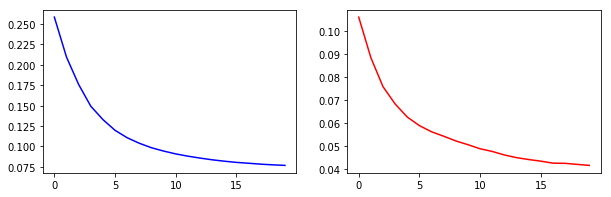

In [78]:
inp = Input(shape=(4,))
x = Dense(6, activation=relu)(inp)
out = Dense(1)(x)

model = Model(inp, out)
#print(model.summary())

model.compile(optimizer='adam',loss='mse', metrics='mae')
model.fit(train_features, train_labels, epochs=20, validation_split=0.1, verbose=0)

fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(model.history.history.get('loss'),'b')
ax[1].plot(model.history.history.get('val_loss'),'r')

In [ ]:
model

In [73]:
def get_model_function(model):
    